In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import signal
import scipy
from scipy.fft import fft, fftfreq
from scipy.integrate import simps
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import os

# Helper methods

In [6]:
def cherchez(estimator, param_grid, search, x_train, y_train):
    """
    This is a helper function for tuning hyperparameters using teh two search methods.
    Methods must be GridSearchCV or RandomizedSearchCV.
    Inputs:
        estimator: Logistic regression, SVM, KNN, etc
        param_grid: Range of parameters to search
        search: Grid search or Randomized search
    Output:
        Returns the estimator instance, clf
    
    """
    clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=10,
                verbose=2,
                random_state=1,
                return_train_score=True
            )
        
    # Fit the model
    clf.fit(X=x_train, y=y_train)
    
    return clf  

In [7]:
def convolve_filter(X_arr, filter_size=10):
  for i in range(X_arr.shape[1]):
    X_arr[:, i] = np.convolve(X_arr[:,i], np.ones(filter_size), 'same') / filter_size
  X_arr = X_arr
  return X_arr

# Load and process data

In [11]:
filename_x = "DDdataset_traditionalClassifiers_X.csv"
filename_y = "DDdataset_traditionalClassifiers_y.csv"

In [12]:
# load labels
df_labels = pd.read_csv(filename_y)
df_labels = df_labels.rename(columns={"0": "labels"})
df_labels = df_labels.drop(["Unnamed: 0"], axis=1)

# load data
df = pd.read_csv(filename_x)
df = df.drop(["Unnamed: 0", "index", "label"], axis=1)
df

,FP1_delta,FP1_theta,FP1_alpha,FP1_beta,FP1_gamma,FP2_delta,FP2_theta,FP2_alpha,FP2_beta,FP2_gamma,F7_delta,F7_theta,F7_alpha,F7_beta,F7_gamma,F3_delta,F3_theta,F3_alpha,F3_beta,F3_gamma,FZ_delta,FZ_theta,FZ_alpha,FZ_beta,FZ_gamma,F4_delta,F4_theta,F4_alpha,F4_beta,F4_gamma,F8_delta,F8_theta,F8_alpha,F8_beta,F8_gamma,FT7_delta,FT7_theta,FT7_alpha,FT7_beta,FT7_gamma,...,T5_delta,T5_theta,T5_alpha,T5_beta,T5_gamma,P3_delta,P3_theta,P3_alpha,P3_beta,P3_gamma,PZ_delta,PZ_theta,PZ_alpha,PZ_beta,PZ_gamma,P4_delta,P4_theta,P4_alpha,P4_beta,P4_gamma,T6_delta,T6_theta,T6_alpha,T6_beta,T6_gamma,O1_delta,O1_theta,O1_alpha,O1_beta,O1_gamma,OZ_delta,OZ_theta,OZ_alpha,OZ_beta,OZ_gamma,O2_delta,O2_theta,O2_alpha,O2_beta,O2_gamma
0,0.084679,0.0,0.115997,0.082479,0.019744,0.088133,0.0,0.110430,0.070396,0.012705,0.064153,0.0,0.090199,0.182913,0.076682,0.079742,0.0,0.093321,0.172404,0.072577,0.108480,0.0,0.100339,0.090486,0.012715,0.115518,0.0,0.101129,0.087595,0.012475,0.089649,0.0,0.118451,0.073469,0.011443,0.080852,0.0,0.089867,0.169361,0.043911,...,0.061857,0.0,0.179996,0.073886,0.011120,0.070813,0.0,0.190211,0.052167,0.007712,0.080893,0.0,0.197698,0.048091,0.006826,0.110337,0.0,0.173042,0.062823,0.008739,0.114026,0.0,0.144599,0.099993,0.021075,0.055364,0.0,0.244696,0.042083,0.006692,0.070791,0.0,0.236837,0.051489,0.011087,0.126537,0.0,0.178526,0.069027,0.008052
1,0.069192,0.0,0.161037,0.102839,0.020045,0.100903,0.0,0.139597,0.072847,0.012830,0.036128,0.0,0.133932,0.147907,0.117779,0.059058,0.0,0.124057,0.203504,0.096409,0.095318,0.0,0.136168,0.105482,0.013141,0.103172,0.0,0.144059,0.105259,0.013371,0.073033,0.0,0.181573,0.076607,0.013207,0.037507,0.0,0.118854,0.232014,0.079418,...,0.066698,0.0,0.210276,0.098723,0.009870,0.040056,0.0,0.283651,0.057202,0.007066,0.040291,0.0,0.297873,0.055393,0.006777,0.050535,0.0,0.284986,0.046636,0.005001,0.076082,0.0,0.242708,0.053399,0.007938,0.041106,0.0,0.285750,0.070588,0.005165,0.036753,0.0,0.294155,0.069974,0.004726,0.054693,0.0,0.272846,0.058551,0.005045
2,0.151981,0.0,0.149584,0.079337,0.027537,0.143654,0.0,0.143600,0.071281,0.018281,0.093129,0.0,0.104374,0.209112,0.172420,0.119742,0.0,0.119634,0.200823,0.100236,0.153811,0.0,0.139832,0.072231,0.016602,0.129321,0.0,0.141700,0.065042,0.012560,0.095776,0.0,0.174001,0.078366,0.024663,0.095898,0.0,0.086985,0.330994,0.138142,...,0.084121,0.0,0.112044,0.177705,0.023042,0.100757,0.0,0.162667,0.128048,0.025124,0.089525,0.0,0.170953,0.083911,0.020287,0.111830,0.0,0.132941,0.067014,0.019280,0.149374,0.0,0.098808,0.074533,0.020761,0.086263,0.0,0.152016,0.159905,0.024379,0.076660,0.0,0.175610,0.150580,0.031221,0.114745,0.0,0.154043,0.112625,0.030609
3,0.067477,0.0,0.124499,0.059305,0.019649,0.087001,0.0,0.118713,0.045064,0.019459,0.071940,0.0,0.082906,0.164898,0.102185,0.076402,0.0,0.087302,0.102042,0.078968,0.090094,0.0,0.098974,0.049938,0.018733,0.091063,0.0,0.110875,0.048890,0.020488,0.080070,0.0,0.122032,0.052041,0.021236,0.070928,0.0,0.070574,0.264502,0.090380,...,0.056659,0.0,0.154216,0.076447,0.010636,0.076212,0.0,0.158605,0.068041,0.014742,0.089516,0.0,0.157068,0.066298,0.016617,0.099950,0.0,0.149380,0.067192,0.020100,0.089039,0.0,0.174171,0.086689,0.016177,0.049096,0.0,0.196875,0.049921,0.009689,0.076124,0.0,0.196261,0.064163,0.013550,0.079536,0.0,0.200773,0.067579,0.013097
4,0.188227,0.0,0.062517,0.102945,0.028448,0.231871,0.0,0.044738,0.071926,0.021576,0.153514,0.0,0.046138,0.143159,0.154736,0.170590,0.0,0.046082,0.141422,0.100410,0.211089,0.0,0.049654,0.082328,0.018130,0.207789,0.0,0.047608,0.077635,0.018126,0.195069,0.0,0.068832,0.066156,0.023886,0.148939,0.0,0.039653,0.124266,0.193698,...,0.159136,0.0,0.125846,0.092817,0.020275,0.209360,0.0,0.072568,0.091249,0.027387,0.209217,0.0,0.062912,0.089413,0.033244,0.202381,0.0,0.066998,0.083747,0.025060,0.121463,0.0,0.100006,0.122049,0.027008,0.109048,0.0,0.173266,0.078135,0.018783,0.101562,0.0,0.163981,0.094968,0.026050,0.089315,0.0,0.173290,0.107934,0.027397
...,...,...,...,...,...,...,...,...,...,...,..

In [13]:
# split to X-input, y-output
X = df
y = df_labels["labels"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1, shuffle=True)

# Support Vector Machine

In [16]:
svc = SVC(C=1.0, kernel='rbf', degree=3, random_state=0) # basic settings
svc.fit(X_train, y_train)
cm_svm = confusion_matrix(y_true=y_test, y_pred=svc.predict(X_test))
print(classification_report(y_true=y_test, y_pred=svc.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, svc.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.87      0.78      0.82        86
           1       0.77      0.86      0.81        73

    accuracy                           0.82       159
   macro avg       0.82      0.82      0.82       159
weighted avg       0.82      0.82      0.82       159

Accuracy score: 0.8176100628930818


In [18]:
C_range = [pow(10, n) for n in range(-4, 4)]
degree_range = [n for n in range(1, 4)]
svm_dist = {
    "C": C_range,
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": degree_range,
    "gamma": ["scale", "auto"]
}
svm_random = cherchez(SVC(), svm_dist, "random", X_train, y_train)
svm_random.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


SVC(C=10, degree=1)

In [21]:
acc = accuracy_score(y_true=y_test, y_pred=svm_random.predict(X_test))
cm_svm_cv = confusion_matrix(y_true=y_test, y_pred=svm_random.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", svm_random.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.8587264847828229
Test accuracy:	 0.8427672955974843


# k-Nearest Neighbours

In [22]:
knn = KNeighborsClassifier()  # basic settings
knn.fit(X_train, y_train)
cm_knn = confusion_matrix(y_true=y_test, y_pred=knn.predict(X_test))
print(classification_report(y_true=y_test, y_pred=knn.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, knn.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        86
           1       0.75      0.79      0.77        73

    accuracy                           0.79       159
   macro avg       0.79      0.79      0.79       159
weighted avg       0.79      0.79      0.79       159

Accuracy score: 0.7861635220125787


In [23]:
knn_dist = {
    "n_neighbors": scipy.stats.randint(1,33),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": scipy.stats.randint(1,1000),
    "p": [1,2]
}
knn_random = cherchez(KNeighborsClassifier(), knn_dist, "random", X_train, y_train)
knn_random.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KNeighborsClassifier(algorithm='kd_tree', leaf_size=394, n_neighbors=8,
                     weights='distance')

In [24]:
acc = accuracy_score(y_true=y_test, y_pred=knn_random.predict(X_test))
cm_knn_cv = confusion_matrix(y_true=y_test, y_pred=knn_random.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", knn_random.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.8496011031222299
Test accuracy:	 0.7924528301886793


# Decision Tree

In [25]:
tree = DecisionTreeClassifier() # basic settings
tree.fit(X_train, y_train)
cm = confusion_matrix(y_true=y_test, y_pred=tree.predict(X_test))
print(classification_report(y_true=y_test, y_pred=tree.predict(X_test)))
print(f"Accuracy score: {accuracy_score(y_test, tree.predict(X_test))}")

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        86
           1       0.70      0.70      0.70        73

    accuracy                           0.72       159
   macro avg       0.72      0.72      0.72       159
weighted avg       0.72      0.72      0.72       159

Accuracy score: 0.7232704402515723


In [26]:
dtc_param = {
    "max_depth": [None, 2, 3, 5, 10, 20],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 5, 10, 20, 50, 100],
    "min_weight_fraction_leaf": [0.],
    "max_features": [None],
    "random_state": [4],
    "max_leaf_nodes": [None], # None = infinity or int,
    'criterion': ["gini", "entropy"]
}

dtc_grid = cherchez(DecisionTreeClassifier(), dtc_param, "grid", X_train, y_train)
dtc_grid.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=4)

In [27]:
acc = accuracy_score(y_true=y_test, y_pred=dtc_grid.predict(X_test))
cfmatrix_rand = confusion_matrix(y_true=y_test, y_pred=dtc_grid.predict(X_test))
print("**Random search results**")
print("Best training accuracy:\t", dtc_grid.best_score_)
print("Test accuracy:\t", acc)

**Random search results**
Best training accuracy:	 0.8334285432876983
Test accuracy:	 0.8050314465408805


## Heatmaps

In [28]:
LABELS = ["calm", "alert"]

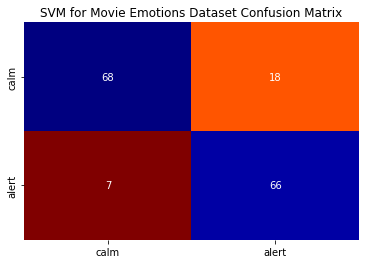

In [33]:
# Support Vector Machine
sns.heatmap(cm_svm_cv, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt="d", cbar=False, cmap="jet_r") # y-axis: true label, x-axis: predicted label
plt.title("SVM for Movie Emotions Dataset Confusion Matrix")
plt.show()

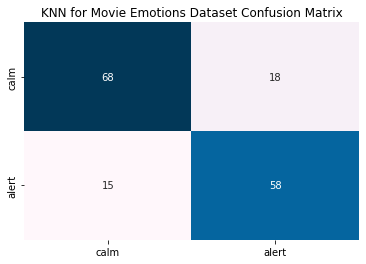

In [30]:
labels = ["calm", "alert"]
sns.heatmap(cm_knn_cv, annot=True, xticklabels=labels, yticklabels=labels, fmt="d", cbar=False, cmap="PuBu")
plt.title("KNN for Movie Emotions Dataset Confusion Matrix")
plt.show()

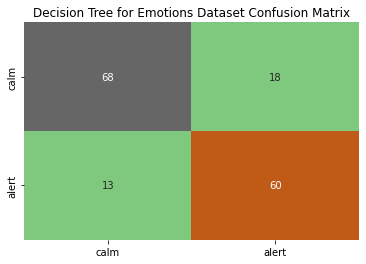

In [34]:
sns.heatmap(cfmatrix_rand, annot=True, xticklabels=labels, yticklabels=labels, fmt="d", cbar=False, cmap="Accent")
plt.title("Decision Tree for Emotions Dataset Confusion Matrix")
plt.show()